<H2>GRaDE Vecht:</H2>
<H3>Stappenplan:</H3>
<UL>
    <LI> Onzekerheid als resultaat van de jackknife op SOBEK hydraulische resultaten.
    </LI>
    <LI> Onzekerheid hydrologie (parameter gevoeligheid) op HBV resultaten.<br>
        Deze onzekerheid komt uit een verzameling SOBEK resultaten gebaseerd op variërende hydrologische parameters
    </LI>
    <LI> Onzekerheid hydraulica (SOBEK resultaten).
    </LI>
    <LI> Combinatie van de onzekerheden tot één onzekerheid.
    </LI>
    <LI> Uitgeintegreerde werklijn
    </LI>
</UL>

In [64]:
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')

import numpy as np
import os.path
import sys
import re
import pprint as pp
import pandas as pd
import matplotlib.pyplot as plt

import gumplot as gplt
import importlib
from uitintegratie import *
from math import *

In [2]:
# tabelsort: sort y by x
def tablesort(x,series):
    n=len(x)
    for i in range(n):
        xx = x[i]
        ss = [s[i] for s in series]
        for j in range(i,-1,-1):
            if j==0 or xx>x[j-1]:
                x[j]=xx
                for s in series:
                    for sr in ss:
                        s[j]=sr
                break
            else:
                x[j] = x[j-1]
                for s in series:
                    s[j] = s[j-1]

# lwrl based on a specified width
def lwrl(x,y,xtgt,width):
    pwr = 2.0
    xmax=np.max(x)
    xmin=np.min(x)
    ytgt = np.array([])
    for xx in xtgt:
        xxp = max(min(xx,xmax),xmin)
        mask = np.where(np.abs(x-xxp)<width)
        xsub = x[mask] - xxp
        ysub = y[mask]
        weights = (1.-(np.abs(xsub)/width)**pwr)**pwr
        a,b = linfit(xsub,ysub,weights)
        ytgt = np.append(ytgt,a*(xx-xxp) + b)
    return ytgt

def loess(x,y,xtgt,width):
    pwr = 2.0
    xmax=np.max(x)
    xmin=np.min(x)
    ytgt = np.array([])
    dydx = np.array([])
    for xx in xtgt:
        xxp = max(min(xx,xmax),xmin)
        mask = np.where(np.abs(x-xxp)<width)
        xsub = x[mask] - xxp
        ysub = y[mask]
        weights = (1.-(np.abs(xsub)/width)**pwr)**pwr
        a,b = linfit(xsub,ysub,weights)
        ytgt = np.append(ytgt,a*(xx-xxp) + b)
        dydx = np.append(dydx,a)
    return ytgt, dydx

                    
# Tabel interpolatie
def interpolate(xx,yy,x,default=np.nan,fraction=-1):
    if x<xx[0] or x>xx[-1]:
        return default
    for i in range(len(xx)-1):
        if (x>=xx[i] and x<=xx[i+1]):
            if fraction<0.0:
                w=(x-xx[i])/(xx[i+1]-xx[i])   # use fraction=0.0 for yy[i] and fraction=1.0 for yy[i+1]
            else:
                w=fraction
            return (1.-w)*yy[i] + w*yy[i+1]

In [3]:
# Relevante herhaaltijden
Tretlist = [2,5,10,20,30,100,300,1250,3000,10000,30000,100000]

<h3>Onzekerheid als resultaat van de jackknife.</h3>

In [4]:
def sorted_ymax_set(nrs):
    ymaxset = {}
    fpath = "Vecht-Sobek3-1D-Qmax-all-50K-jackknifes"
    basename = "Qmax_all_jackknife%2.2d.csv"

    for nr in nrs:
        fname = os.path.join(fpath,basename%nr)
        number = []
        yearmax = []
        t_real = []
        t_run = []
        with open(fname,"r") as fin:
            fin.readline()
            for line in fin.readlines():
                elements = line.split(',')
                number.append(int(elements[0]))
                yearmax.append(float(elements[1]))
                t_real.append(elements[2])
                t_run.append((elements[3]))
        ymaxset[nr] = np.array(sorted(yearmax))
    return ymaxset

In [5]:
# Read reference data
fpath_ref = "."
basename_ref = "Qmax-all-referentie-02001-52000.csv"
fname_ref = os.path.join(fpath_ref,basename_ref)
number = []
yearmax = []
t_real = []
t_run = []
with open(fname_ref,"r") as fin:
    fin.readline()
    for line in fin.readlines():
        elements = line.split(',')
        number.append(int(elements[0]))
        yearmax.append(float(elements[1]))
        t_real.append(elements[2])
        t_run.append((elements[3]))
ymax_ref = np.array(sorted(yearmax))


In [6]:
# jackknife estimates and errors
# assume x is a jackknife set
def jackknife(x, xref):
    n = len(x)
    pseudo = np.array([])
    m0 = np.mean(x)
    for xx in x:
#        pseudo=np.append(pseudo, n*xref - (n-1)*xx)
        pseudo=np.append(pseudo, xref - (n-1)*(xx-xref))
    return np.mean(pseudo),(np.var(pseudo)/n)**0.5

# The pseudo values can be seen as a sample of nearly iid values 
# and their mean an unbiased estimate.
# then the variance of the mean pseudo value is the variance of the estimate

In [7]:
# Resultaten Henk van den Brink
# bepaald met de methode GEV-fit
# fpath = "werklijnen"
fpath_meteo = "results_jackknife"
basename = "werklijn_OZA_Vecht_T%3d.txt"
ymaxset_hvdb = {}
thresholds = [100,200,500]
for threshold in thresholds:
    fname = os.path.join(fpath_meteo,basename%threshold)
    sgv   = []  # standardized gumbel variate
    yearmax  = []  # year maxima
    jkstd = []  # jackknife standard error
    with open(fname,"r") as fin:
        fin.readline()
        for line in fin.readlines():
            if line[0]!='#':
                elements = re.split(r"[\s\t]+",line.strip())
                sgv.append(float(elements[0]))
                yearmax.append(float(elements[1]))
                jkstd.append(float(elements[2]))
    ymaxset_hvdb[threshold] = {'sgv':np.array(sgv), 'Q':np.array(yearmax),  'jkstd':np.array(jkstd)}

In [8]:
# fit meteo (jackknife) standard deviations into lookup-table format
meteo_uncertainty = {}
for threshold in thresholds:
    meteo_uncertainty[threshold] = {'Qref':ymaxset_hvdb[threshold]['Q'], 'sigma':ymaxset_hvdb[threshold]['jkstd']}
    tablesort(meteo_uncertainty[threshold]['Qref'],[meteo_uncertainty[threshold]['sigma']])

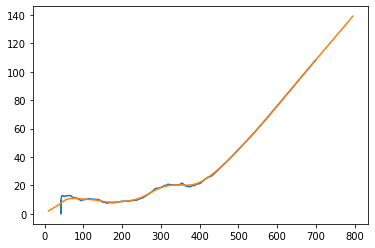

In [9]:
plt.plot(meteo_uncertainty[200]['Qref'],meteo_uncertainty[200]['sigma'])
smoothy = lwrl(meteo_uncertainty[200]['Qref'],meteo_uncertainty[200]['sigma'],np.arange(10,800,5),50)
plt.plot(np.arange(10,800,5),smoothy)


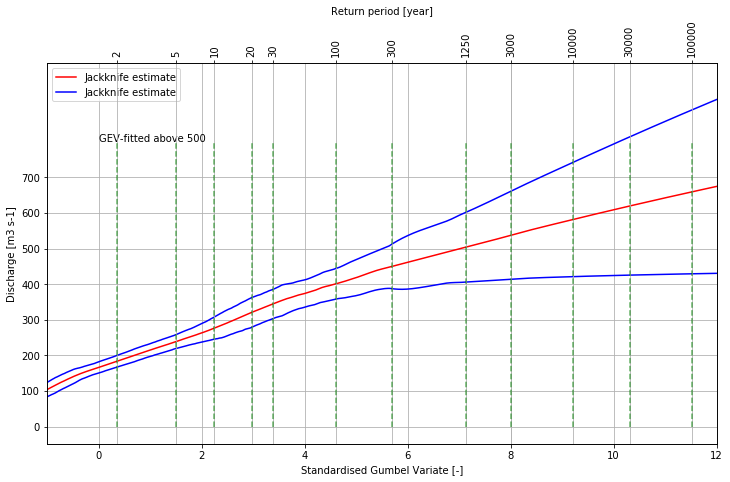

In [10]:
threshold = 500

ymax = 800
yrange = 100

ax=plt.gca()
fig=plt.gcf()
jk_estplot_hvdb = ax.plot(ymaxset_hvdb[threshold]['sgv'],ymaxset_hvdb[threshold]['Q'],'r-',label='Jackknife estimate')
jk_upperplot_hvdb = ax.plot(ymaxset_hvdb[threshold]['sgv'], 
                       ymaxset_hvdb[threshold]['Q'] + 2.*ymaxset_hvdb[threshold]['jkstd'],'b-', 
                       label='Jackknife estimate')

jk_upperplot_hvdb = ax.plot(ymaxset_hvdb[threshold]['sgv'],
                       ymaxset_hvdb[threshold]['Q'] - 2.*ymaxset_hvdb[threshold]['jkstd'],'b-')

#jk_refplot = ax.plot(sgv,ymax_ref,'b-',label='Reference')
#jk_upperplot = ax.plot(sgv,ymax_ref + 2*jackknife_std,'g-',label='Jackknife 2se-interval')
#jk_lowerplot = ax.plot(sgv,ymax_ref - 2*jackknife_std,'g-')

fig.set_size_inches(12,7)
lgnd = ax.legend(loc="upper left")
ax.set_xlim([-1,12])
gplt.add_gum_axis(Tretlist,ax,ymax,yrange)    

namelbl = ax.text(0,800,'GEV-fitted above %d'%threshold)

In [11]:
#Alle Henk-van-den-Brink curves samen met de SEAS5 data
def plot_hvdb0(threshold, color, ax):
    jk_estplot_hvdb = ax.plot(ymaxset_hvdb[threshold]['sgv'],ymaxset_hvdb[threshold]['Q'],color+'-',label='Threshold = %d years'%threshold)
    jk_upperplot_hvdb = ax.plot(ymaxset_hvdb[threshold]['sgv'], 
                           ymaxset_hvdb[threshold]['Q'] + 1.96*ymaxset_hvdb[threshold]['jkstd'],color+'--') 

    jk_lowerplot_hvdb = ax.plot(ymaxset_hvdb[threshold]['sgv'],
                           ymaxset_hvdb[threshold]['Q'] - 1.96*ymaxset_hvdb[threshold]['jkstd'],color+'--')

def plot_hvdb1(threshold, color, ax):
    color = 'r'
    jk_estplot_hvdb = ax.plot(ymaxset_hvdb[threshold]['sgv'],ymaxset_hvdb[threshold]['Q'],color+'-',label = 'werklijn')
    color = 'b'
    jk_upperplot_hvdb = ax.plot(ymaxset_hvdb[threshold]['sgv'], 
                           ymaxset_hvdb[threshold]['Q'] + 1.96*ymaxset_hvdb[threshold]['jkstd'],color+'--', label = '95% interval meteo (jackknife)') 

    jk_lowerplot_hvdb = ax.plot(ymaxset_hvdb[threshold]['sgv'],
                           ymaxset_hvdb[threshold]['Q'] - 1.96*ymaxset_hvdb[threshold]['jkstd'],color+'--')

    color = 'g'
    jk_upperplot_total = ax.plot(ymaxset_hvdb[threshold]['sgv'], 
                           ymaxset_hvdb[threshold]['Q'] + 1.96*ymaxset_hvdb[threshold]['sigma'],color+'-', label = '95% interval totale onzekerheid') 

    jk_lowerplot_hvdb = ax.plot(ymaxset_hvdb[threshold]['sgv'],
                           ymaxset_hvdb[threshold]['Q'] - 1.96*ymaxset_hvdb[threshold]['sigma'],color+'-')

    ti = plt.title('Centrale lijn en 95%%-interval voor meteo onzekerheid en totale onzekerheid, threshold = %d'%threshold)

In [12]:
# Load SEAS5 set:
basename = os.path.join("SEAS5","Qmax_all_periods_sorted.csv")
fname = os.path.join(fpath_meteo,basename)
sgv   = []  # standardized gumbel variate
yearmax  = []  # year maxima
jkstd = []  # jackknife standard error
ymax = []
with open(fname,"r") as fin:
    fin.readline()
    for line in fin.readlines():
        if line[0]!='#':
            elements = re.split(r",",line.strip())
            ymax.append(float(elements[1]))
NN = len(ymax)
ymax.sort()
ymaxset_seas5 = {'sgv':-np.log(-np.log((np.arange(NN)+1-0.3)/(NN+0.4))), 'Q':np.array(ymax)}

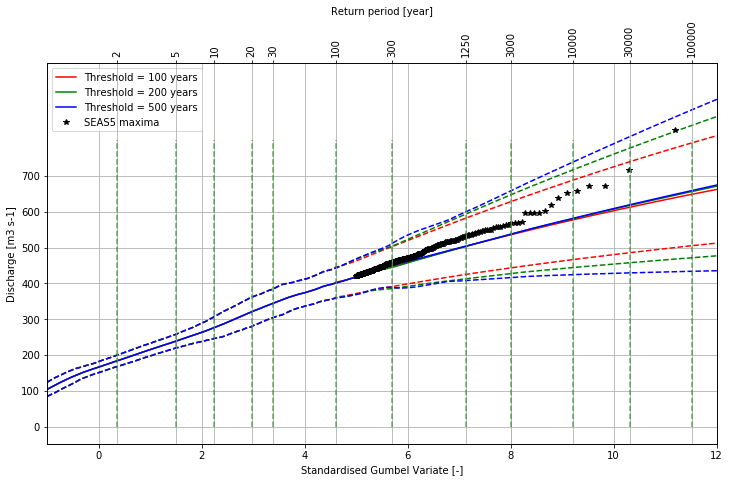

In [13]:
ymax = 800
yrange = 100

ax=plt.gca()
fig=plt.gcf()

plot_hvdb0(100,'r',ax)
plot_hvdb0(200,'g',ax)
plot_hvdb0(500,'b',ax)
#ax.plot(ymaxset_seas5['sgv'],ymaxset_seas5['Q'],'k*', label="SEAS5 maxima")
selection = (ymaxset_seas5['sgv']>5)
ax.plot(ymaxset_seas5['sgv'][selection],ymaxset_seas5['Q'][selection],'k*', label="SEAS5 maxima")
fig.set_size_inches(12,7)
lgnd = ax.legend(loc="upper left")
ax.set_xlim([-1,12])
gplt.add_gum_axis(Tretlist,ax,ymax,yrange)    
plt.show()


In [14]:
#Beide plaatjes over elkaar gelegd:
def plot_hvdb(threshold):
    ymax = 800
    yrange = 100

    ax=plt.gca()
    fig=plt.gcf()
    jk1plot = ax.plot(stdgumval,my_set[1],'c-',label='Jackknife members')
    for ijack in range(1,njack):
         jk_allplot = ax.plot(stdgumval,my_set[ijack+1],'c-')
    # jk_estplot = ax.plot(stdgumval,jackknife_est,'r-',label='Jackknife estimate')
    jk_refplot = ax.plot(stdgumval,ymax_ref,'b-',label='Reference')
    jk_upperplot = ax.plot(stdgumval,ymax_ref + 2*jackknife_std,'g-',label='Jackknife 2se-interval')
    jk_lowerplot = ax.plot(stdgumval,ymax_ref - 2*jackknife_std,'g-')

    jk_estplot_hvdb = ax.plot(ymaxset_hvdb[threshold]['sgv'],ymaxset_hvdb[threshold]['Q'],'r-',label='Jackknife estimate')
    jk_upperplot_hvdb = ax.plot(ymaxset_hvdb[threshold]['sgv'], 
                           ymaxset_hvdb[threshold]['Q'] + 2.*ymaxset_hvdb[threshold]['jkstd'],'b-', 
                           label='Jackknife estimate')

    jk_upperplot_hvdb = ax.plot(ymaxset_hvdb[threshold]['sgv'],
                           ymaxset_hvdb[threshold]['Q'] - 2.*ymaxset_hvdb[threshold]['jkstd'],'b-')


    fig.set_size_inches(12,7)
    lgnd = ax.legend(loc="upper left")
    ax.set_xlim([-1,12])
    gplt.add_gum_axis(Tretlist,ax,ymax,yrange)    
    namelbl = ax.text(0,800,'GEV-fitted above %d'%threshold)
    #plt.show

In [15]:
# Hulp routines voor de uitintegratie
def normal_cdf(x,parms):
    mu = parms[0]
    sigma = parms[1]
    return (1.0 + erf((x-mu) / sigma / sqrt(2.0))) / 2.0

def normal_pdf(x,parms):
    mu = parms[0]
    sigma = parms[1]
    return exp(-0.5*((x-mu)/2./sigma)**2)/(sigma*(2*pi)**0.5)

In [16]:
# Voer een uitintegratie uit voor de oude resultaten
q_min = 50
q_max = 1000
uitgeintegreerd = {}
for threshold in [100, 200, 500]:
    uitgeintegreerd[threshold] = {}
    nx_old = len(ymaxset_hvdb[threshold]['sgv'])
    parms = {'distpar':[(ymaxset_hvdb[threshold]['Q'][i], ymaxset_hvdb[threshold]['jkstd'][i]) for i in range(nx_old)],
                  'F':list(np.exp(-np.exp(-ymaxset_hvdb[threshold]['sgv'])))}
    uitgeintegreerd[threshold]['levels'] = np.array(list(range(q_min, q_max, 100)))
    cdf = outintegrate(parms, uitgeintegreerd[threshold]['levels'], normal_cdf)
    cdf2= outintegrateExtrapLoglin(parms, uitgeintegreerd[threshold]['levels'], normal_cdf,10,20)
    uitgeintegreerd[threshold]['sgv'] = -np.log(-np.log(cdf))
    uitgeintegreerd[threshold]['sgv2'] = -np.log(-np.log(cdf2))    

C:\Users\leander\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  """


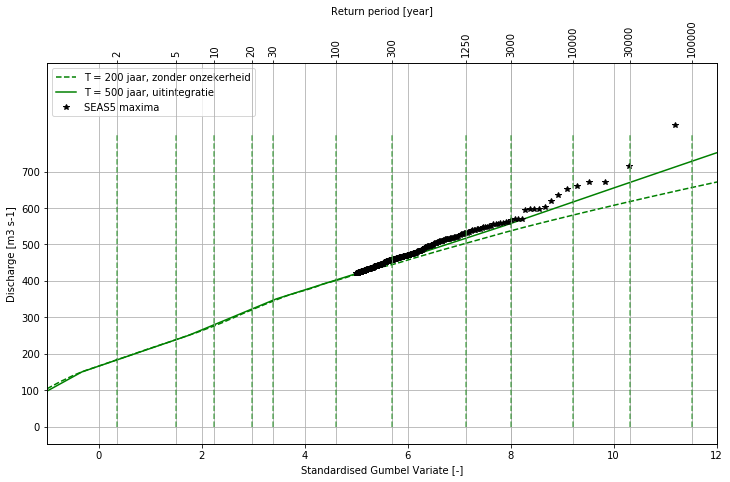

In [40]:
ymax = 800
yrange = 100

ax=plt.gca()
fig=plt.gcf()

#ax.plot(ymaxset_hvdb[100]['sgv'],ymaxset_hvdb[100]['Q'],'r--',label='T = 100 jaar, zonder onzekerheid')
#ax.plot(uitgeintegreerd[100]['sgv'] ,uitgeintegreerd[100]['levels'],'r-',label="T = 100 jaar, uitintegratie")

ax.plot(ymaxset_hvdb[200]['sgv'],ymaxset_hvdb[200]['Q'],'g--',label='T = 200 jaar, zonder onzekerheid')
ax.plot(uitgeintegreerd[200]['sgv'] ,uitgeintegreerd[200]['levels'],'g-',label="T = 500 jaar, uitintegratie") 

#ax.plot(ymaxset_hvdb[500]['sgv'],ymaxset_hvdb[500]['Q'],'b--',label='T = 500 jaar, zonder onzekerheid')
#ax.plot(uitgeintegreerd[500]['sgv'] ,uitgeintegreerd[500]['levels'],'b-',label="T = 500 jaar, uitintegratie") 

#ax.plot(ymaxset_seas5['sgv'],ymaxset_seas5['Q'],'k*', label="SEAS5 maxima")
selection = (ymaxset_seas5['sgv']>5)
ax.plot(ymaxset_seas5['sgv'][selection],ymaxset_seas5['Q'][selection],'k*', label="SEAS5 maxima")
fig.set_size_inches(12,7)
lgnd = ax.legend(loc="upper left")
ax.set_xlim([-1,12])
gplt.add_gum_axis(Tretlist,ax,ymax,yrange)    
plt.show()


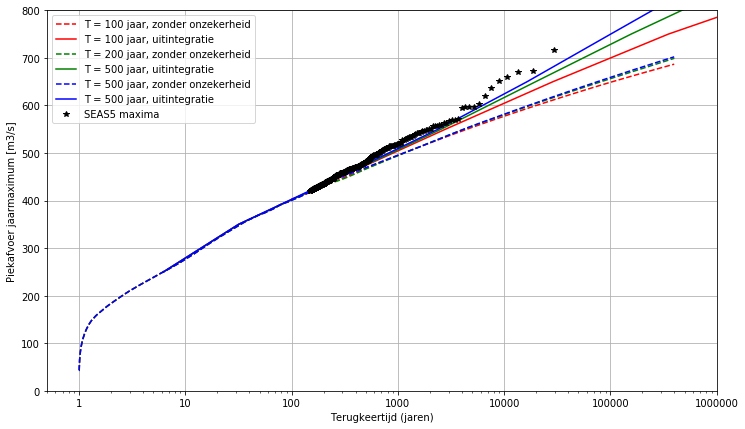

In [39]:
ymax = 800
yrange = 100

from matplotlib.ticker import FormatStrFormatter

ax=plt.gca()
fig=plt.gcf()
def retp(sgv):
    return 1./(1.-np.exp(-np.exp(-sgv)))

ax.plot(retp(ymaxset_hvdb[100]['sgv']),ymaxset_hvdb[100]['Q'],'r--',label='T = 100 jaar, zonder onzekerheid')
ax.plot(retp(uitgeintegreerd[100]['sgv'][2:]) ,uitgeintegreerd[100]['levels'][2:],'r-',label="T = 100 jaar, uitintegratie")

ax.plot(retp(ymaxset_hvdb[200]['sgv']),ymaxset_hvdb[200]['Q'],'g--',label='T = 200 jaar, zonder onzekerheid')
ax.plot(retp(uitgeintegreerd[200]['sgv'][2:]) ,uitgeintegreerd[200]['levels'][2:],'g-',label="T = 500 jaar, uitintegratie") 

ax.plot(retp(ymaxset_hvdb[500]['sgv']),ymaxset_hvdb[500]['Q'],'b--',label='T = 500 jaar, zonder onzekerheid')
ax.plot(retp(uitgeintegreerd[500]['sgv'][2:]) ,uitgeintegreerd[500]['levels'][2:],'b-',label="T = 500 jaar, uitintegratie") 

#ax.plot(ymaxset_seas5['sgv'],ymaxset_seas5['Q'],'k*', label="SEAS5 maxima")
selection = (ymaxset_seas5['sgv']>5)
ax.plot(retp(ymaxset_seas5['sgv'][selection]),ymaxset_seas5['Q'][selection],'k*', label="SEAS5 maxima")
fig.set_size_inches(12,7)
lgnd = ax.legend(loc="upper left")
ax.set_xlim([0.5,1E+6])
ax.set_ylim([0,800])
ax.set_xscale('log')
ax.set_ylabel('Piekafvoer jaarmaximum [m3/s]')
ax.set_xlabel('Terugkeertijd (jaren)')
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.grid()
plt.show()


In [55]:
def retp(sgv):
    return 1./(1.-np.exp(-np.exp(-sgv)))

retp(8.)

2981.4580149965427

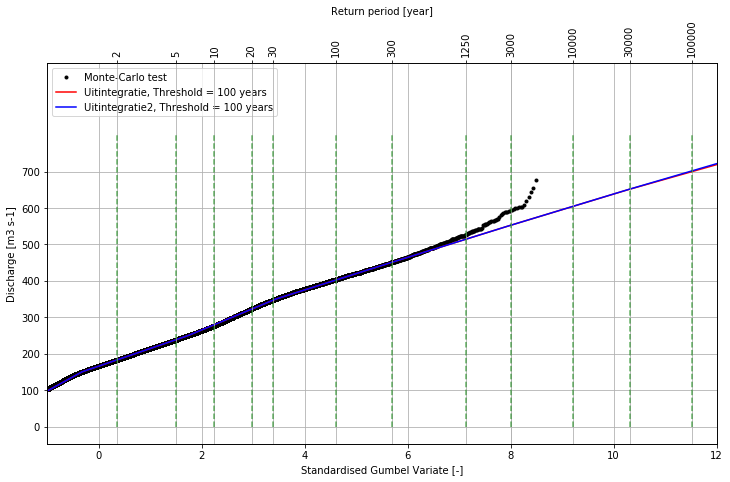

In [15]:
# Monte-Carlo check van uitintegratie:
# Sample uit de werklijn met zijn onzekerheidsbanden tot een grote populatie
# Maak van die populatie weer een gumbelplot

threshold = 100
ns1 = 10000
ns2 = 10


ymax = 800
yrange = 100

ax=plt.gca()
fig=plt.gcf()

populatie = np.array([])
sgv=-np.log(-np.log(np.random.uniform(size=ns1)))

for sgvval in sgv:
    mu = interpolate(ymaxset_hvdb[threshold]['sgv'],ymaxset_hvdb[threshold]['Q'],sgvval)
    sigma = interpolate(ymaxset_hvdb[threshold]['sgv'],ymaxset_hvdb[threshold]['jkstd'],sgvval)
    populatie = np.append(populatie, np.random.normal(mu,sigma,ns2))

populatie_q = np.sort(populatie)
populatie_sgv = -np.log(-np.log(((np.arange(len(populatie))+1)-0.3)/(len(populatie)+0.4)))

ax.plot(populatie_sgv,populatie_q,'.k', label='Monte-Carlo test')
ax.plot(uitgeintegreerd[threshold]['sgv'] ,uitgeintegreerd[threshold]['levels'],'r-',label="Uitintegratie, Threshold = %d years"%threshold) 
ax.plot(uitgeintegreerd[threshold]['sgv2'] ,uitgeintegreerd[threshold]['levels'],'b-',label="Uitintegratie2, Threshold = %d years"%threshold) 
fig.set_size_inches(12,7)
lgnd = ax.legend(loc="upper left")
ax.set_xlim([-1,12])
gplt.add_gum_axis(Tretlist,ax,ymax,yrange)    
plt.show()




<h3>Onzekerheid als resultaat van rainfall-runoff (HBV) parameters.</h3>

In [70]:
# drive = "P:\\"
# P:\11205237-grade\MODELS\Vecht\SOBEK3_gevoeligheidsanalyse_hydrologie_1D\_results_all\csv\all-scenario00-08
# fpath_hbv = os.path.join(drive, 
#                         '11205237-grade', 
#                         'MODELS','Vecht', 
#                         'SOBEK3_gevoeligheidsanalyse_hydrologie_1D',
#                         '_results_all','csv', 'all-scenario00-08')
skip_row = 1 # header row
skip_col = 5 # name column
fpath_hbv = os.path.join("results_hydrology","all-scenario00-08")
basename = "Qmax_all_scenarios_Dalfsen.csv"
fname = os.path.join(fpath_hbv,basename)

threshold = 200
sgv_tgt=ymaxset_hvdb[threshold]['sgv']
ymaxset = []
with open(fname,"r") as fin:
    for irow in range(skip_row):
        line = fin.readline()
        elements = re.split(r",",line.strip())
        ranks = [elm[4:8] for elm in elements]
    for line in fin.readlines():
        if line[0]!='#':
            elements = re.split(r",",line.strip())
            for icol in range(skip_col):
                elements.pop(0)
            ymaxset.append(np.array([float(element) for element in elements]))
    ymaxlengths = [len(ymax) for ymax in ymaxset]
    if min(ymaxlengths)==max(ymaxlengths):
        hbv_uncertainty = {'Qref':np.array([]), 'sigma':np.array([])}
        for imax in range(min(ymaxlengths)):
            sample = [ymax[imax] for ymax in ymaxset]
            refstd = np.std(sample)   # reference value over all sample members
            jckstd = np.array([np.std(np.delete(sample,i)) for i in range(len(sample))])
        #   print (np.mean(sample), np.std(sample), jackknife(jckstd, refstd))
            qref  = np.mean(sample)
            sigma = jackknife(jckstd, refstd)[0]
            hbv_uncertainty['Qref'] = np.append(hbv_uncertainty['Qref'], qref)
            hbv_uncertainty['sigma'] = np.append(hbv_uncertainty['sigma'], sigma)
    else:
        print ("Not all sets have the same length !")        
        print (ymaxlengths)
tablesort(hbv_uncertainty['Qref'],[hbv_uncertainty['sigma']])

<h3>Onzekerheid als resultaat van de hydraulische (SOBEK) simulatie.</h3>

In [71]:
# drive = "P:\\"
# P:\11205237-grade\MODELS\Vecht\SOBEK3_OZA_hydraulica_1D2D\results_20220412\output
# fpath_sobek = os.path.join(drive, 
#                         '11205237-grade', 
#                         'MODELS','Vecht', 
#                         'SOBEK3_OZA_hydraulica_1D2D',
#                         'results_20220412','output')
# basename = "read_Qmax_sums_results.xlsx"
fpath_sobek = os.path.join("results_hydraulica","output")
basename = "read_Qmax_sums_results.csv"
fname = os.path.join(fpath_sobek, basename)
skip_row = 1
skip_col = 1
ymaxset = []
with open(fname,"r") as fin:
    for irow in range(skip_row):
        line = fin.readline()
        elements = re.split(r",",line.strip())
        ranks = [elm[4:8] for elm in elements]
    for line in fin.readlines():
        if line[0]!='#':
            elements = re.split(r";",line.strip())
            for icol in range(skip_col):
                elements.pop(0)
            ymaxset.append(np.array([float(element.replace(',','.')) for element in elements]))
    ymaxlengths = [len(ymax) for ymax in ymaxset]
    if min(ymaxlengths)==max(ymaxlengths):
        sbk_uncertainty = {'Qref':np.array([]), 'sigma':np.array([])}
        for imax in range(min(ymaxlengths)):
            sample = [ymax[imax] for ymax in ymaxset]
            refstd = np.std(sample)   # reference value over all sample members
            jckstd = np.array([np.std(np.delete(sample,i)) for i in range(len(sample))])
        #   print (np.mean(sample), np.std(sample), jackknife(jckstd, refstd))
            qref  = np.mean(sample)
            sigma = jackknife(jckstd, refstd)[0]
            sbk_uncertainty['Qref'] = np.append(sbk_uncertainty['Qref'], qref)
            sbk_uncertainty['sigma'] = np.append(sbk_uncertainty['sigma'], sigma)
    else:
        print ("Not all sets have the same length !")
        print (ymaxlengths)
tablesort(sbk_uncertainty['Qref'],[sbk_uncertainty['sigma']])


<h3>Combinatie van de drie onzekerheidsbijdragen.</h3>

In [72]:
# smooth and extrapolate sigma versus Qref
width = 100
for threshold in thresholds:
    meteo_uncertainty[threshold]['tbl_q'] = np.arange(10,800,5)
    meteo_uncertainty[threshold]['tbl_sigma'] = \
          lwrl(meteo_uncertainty[threshold]['Qref'],meteo_uncertainty[threshold]['sigma'], \
          meteo_uncertainty[threshold]['tbl_q'],width)
    
hbv_uncertainty['tbl_q'] = np.arange(10,800,5)
hbv_uncertainty['tbl_sigma'] = lwrl(hbv_uncertainty['Qref'],hbv_uncertainty['sigma'], hbv_uncertainty['tbl_q'],width)

sbk_uncertainty['tbl_q'] = np.arange(10,800,5)
sbk_uncertainty['tbl_sigma'] = lwrl(sbk_uncertainty['Qref'],sbk_uncertainty['sigma'], sbk_uncertainty['tbl_q'],width)


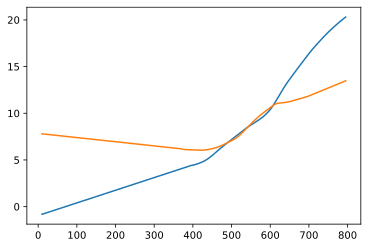

In [73]:
plt.plot(sbk_uncertainty['tbl_q'],sbk_uncertainty['tbl_sigma'])
#plt.plot(sbk_uncertainty['Qref'],sbk_uncertainty['sigma'])

plt.plot(hbv_uncertainty['tbl_q'],hbv_uncertainty['tbl_sigma'])
#plt.plot(hbv_uncertainty['Qref'],hbv_uncertainty['sigma'])

In [76]:
# Op elk punt in de referentie werklijn:
# Lookup jackknife sigma per Qref
# lookup hydrolgic sigma per Qref
# lookup hydraulic sigma per Qref
# sommeer the sigma's kwadratisch om de totale sigma te krijgen
# De gebruikte referentie is hier ymaxset_hvdb[threshold]['Q'] tegen ymaxset_hvdb[threshold]['sgv']
for threshold in thresholds:
    ymaxset_hvdb[threshold]['sigma'] = np.array([])
    for sgv, q in zip(ymaxset_hvdb[threshold]['sgv'], ymaxset_hvdb[threshold]['Q']):
        sigma_meteo = interpolate(meteo_uncertainty[threshold]['tbl_q'], meteo_uncertainty[threshold]['tbl_sigma'], q)
        sigma_hbv   = interpolate(hbv_uncertainty['tbl_q'], hbv_uncertainty['tbl_sigma'], q)
        sigma_sbk   = interpolate(sbk_uncertainty['tbl_q'], sbk_uncertainty['tbl_sigma'], q)
        sigma_tot   = sqrt(sigma_meteo**2. + sigma_hbv**2. + sigma_sbk**2.)
        ymaxset_hvdb[threshold]['sigma'] = np.append(ymaxset_hvdb[threshold]['sigma'], sigma_tot)

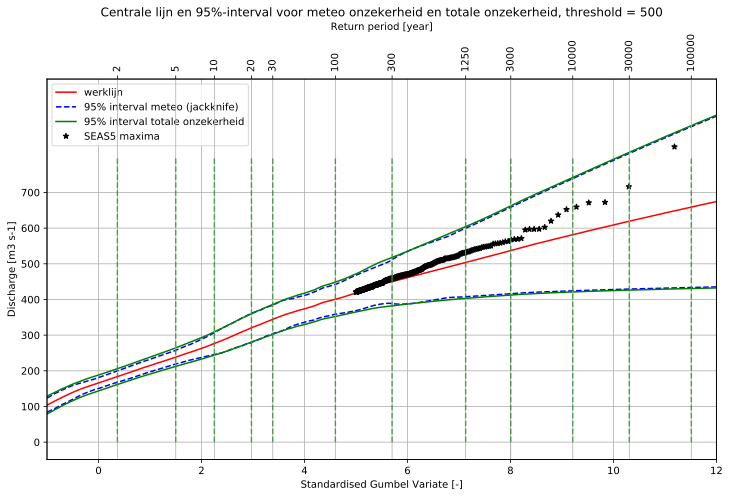



Tr (jaar),  sigma_meteo,    sigma_hbv,    sigma_sbk,    sigma_tot,     delta[%]

       2,         8.76,         7.02,         1.54,        11.33,        22.70
       5,        11.20,         6.78,         2.28,        13.29,        15.71
      10,        15.08,         6.61,         2.80,        16.70,         9.71
      20,        18.99,         6.41,         3.39,        20.33,         6.58
      30,        20.14,         6.31,         3.71,        21.43,         6.01
     100,        23.36,         6.08,         4.45,        24.55,         4.83
     300,        33.60,         6.21,         5.48,        34.60,         2.90
    1250,        50.29,         7.15,         7.30,        51.32,         2.00
    3000,        62.70,         8.34,         8.40,        63.81,         1.74
   10000,        80.68,        10.03,         9.63,        81.87,         1.45
   30000,        97.23,        11.07,        11.64,        98.55,         1.34
  100000,       115.06,        11.35,        14.

In [77]:
ymax = 800
yrange = 100
threshold = 500
ax=plt.gca()
fig=plt.gcf()

plot_hvdb1(threshold,'g',ax)
#ax.plot(ymaxset_seas5['sgv'],ymaxset_seas5['Q'],'k*', label="SEAS5 maxima")
selection = (ymaxset_seas5['sgv']>5)
ax.plot(ymaxset_seas5['sgv'][selection],ymaxset_seas5['Q'][selection],'k*', label="SEAS5 maxima")
fig.set_size_inches(12,7)
lgnd = ax.legend(loc="upper left")
ax.set_xlim([-1,12])
gplt.add_gum_axis(Tretlist,ax,ymax,yrange)    
plt.show()

# dump een tabel voor een geselecteerde set van herhalingstijden
print ("\n")
print("%8s, %12s, %12s, %12s, %12s, %12s\n"%('Tr (jaar)','sigma_meteo','sigma_hbv','sigma_sbk','sigma_tot', 'delta[%]'))
for Tr in Tretlist:
    sgv = -np.log(-np.log(1.-1./Tr))
    Qref = interpolate(ymaxset_hvdb[threshold]['sgv'],ymaxset_hvdb[threshold]['Q'],sgv)
    sigma_hbv = interpolate(hbv_uncertainty['tbl_q'], hbv_uncertainty['tbl_sigma'], Qref)
    sigma_sbk = interpolate(sbk_uncertainty['tbl_q'], sbk_uncertainty['tbl_sigma'], Qref)
    sigma_meteo = interpolate(meteo_uncertainty[threshold]['tbl_q'], meteo_uncertainty[threshold]['tbl_sigma'], Qref)
    sigma_tot   = sqrt(sigma_meteo**2. + sigma_hbv**2. + sigma_sbk**2.)
    delta = (sigma_tot - sigma_meteo)/sigma_tot*100.
    print("%8d, %12.2f, %12.2f, %12.2f, %12.2f, %12.2f"%(Tr,sigma_meteo,sigma_hbv,sigma_sbk,sigma_tot,delta))
    


In [78]:
# Voer een uitintegratie uit voor de totale onzekerheid
q_min = 50
q_max = 1000
uitgeintegreerd_all = {}
for threshold in [100, 200, 500]:
    uitgeintegreerd_all[threshold] = {}
    nx_old = len(ymaxset_hvdb[threshold]['sgv'])
    parms = {'distpar':[(ymaxset_hvdb[threshold]['Q'][i], ymaxset_hvdb[threshold]['sigma'][i]) for i in range(nx_old)],
                   'F':list(np.exp(-np.exp(-ymaxset_hvdb[threshold]['sgv'])))}
    uitgeintegreerd_all[threshold]['levels'] = np.array(list(range(q_min, q_max, 100)))
    cdf = outintegrate(parms, uitgeintegreerd_all[threshold]['levels'], normal_cdf)
    uitgeintegreerd_all[threshold]['sgv'] = -np.log(-np.log(cdf))

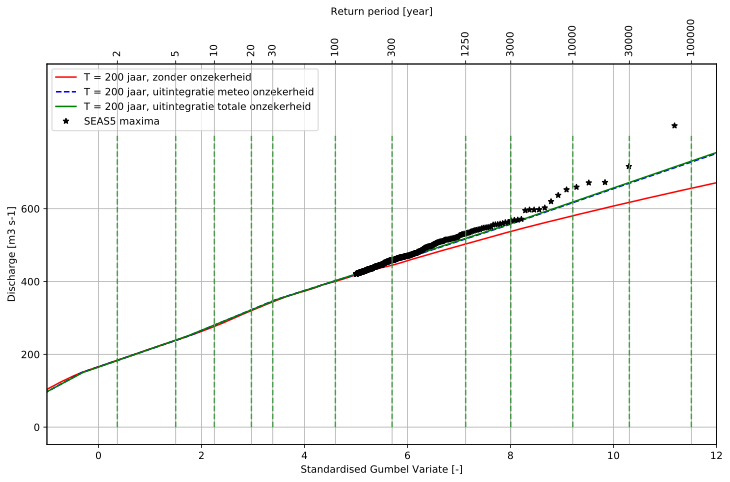

In [81]:
ymax = 800
yrange = 200

ax=plt.gca()
fig=plt.gcf()
threshold = 200

ax.plot(ymaxset_hvdb[threshold]['sgv'],ymaxset_hvdb[threshold]['Q'],'r-',label='T = %d jaar, zonder onzekerheid'%threshold)
ax.plot(uitgeintegreerd[threshold]['sgv'] ,uitgeintegreerd[threshold]['levels'],'b--',label='T = %d jaar, uitintegratie meteo onzekerheid'%threshold)
ax.plot(uitgeintegreerd_all[threshold]['sgv'] ,uitgeintegreerd_all[threshold]['levels'],'g-',label='T = %d jaar, uitintegratie totale onzekerheid'%threshold)

#ax.plot(ymaxset_seas5['sgv'],ymaxset_seas5['Q'],'k*', label="SEAS5 maxima")
selection = (ymaxset_seas5['sgv']>5)
ax.plot(ymaxset_seas5['sgv'][selection],ymaxset_seas5['Q'][selection],'k*', label="SEAS5 maxima")
fig.set_size_inches(12,7)
lgnd = ax.legend(loc="upper left")
ax.set_xlim([-1,12])
gplt.add_gum_axis(Tretlist,ax,ymax,yrange)    
plt.show()


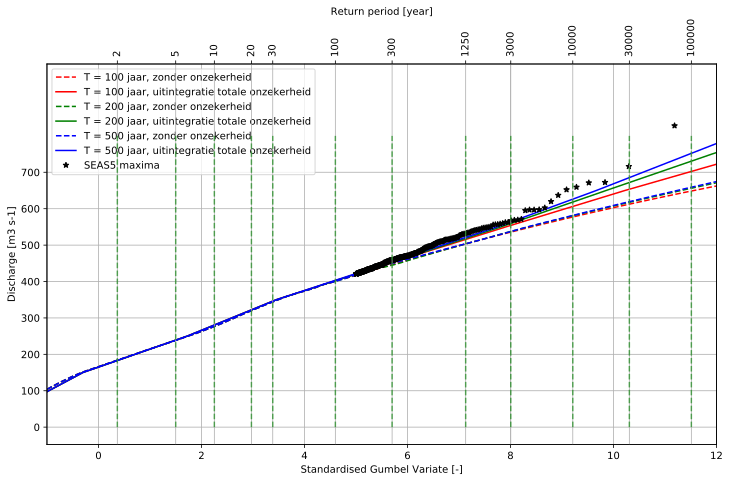

In [82]:
ymax = 800
yrange = 100

ax=plt.gca()
fig=plt.gcf()

ax.plot(ymaxset_hvdb[100]['sgv'],ymaxset_hvdb[100]['Q'],'r--',label='T = 100 jaar, zonder onzekerheid')
ax.plot(uitgeintegreerd_all[100]['sgv'] ,uitgeintegreerd_all[100]['levels'],'r-',label="T = 100 jaar, uitintegratie totale onzekerheid")

ax.plot(ymaxset_hvdb[200]['sgv'],ymaxset_hvdb[200]['Q'],'g--',label='T = 200 jaar, zonder onzekerheid')
ax.plot(uitgeintegreerd_all[200]['sgv'] ,uitgeintegreerd_all[200]['levels'],'g-',label="T = 200 jaar, uitintegratie totale onzekerheid") 

ax.plot(ymaxset_hvdb[500]['sgv'],ymaxset_hvdb[500]['Q'],'b--',label='T = 500 jaar, zonder onzekerheid')
ax.plot(uitgeintegreerd_all[500]['sgv'] ,uitgeintegreerd_all[500]['levels'],'b-',label="T = 500 jaar, uitintegratie totale onzekerheid") 

#ax.plot(ymaxset_seas5['sgv'],ymaxset_seas5['Q'],'k*', label="SEAS5 maxima")
selection = (ymaxset_seas5['sgv']>5)
ax.plot(ymaxset_seas5['sgv'][selection],ymaxset_seas5['Q'][selection],'k*', label="SEAS5 maxima")
fig.set_size_inches(12,7)
lgnd = ax.legend(loc="upper left")
ax.set_xlim([-1,12])
gplt.add_gum_axis(Tretlist,ax,ymax,yrange)    
plt.show()


In [107]:
logtscale = True    # Deltares-style log T abcissa
# logtscale = False   # Standard gumbel-axis 
ymax = 800
yrange = 100

from matplotlib.ticker import FormatStrFormatter

ax=plt.gca()
fig=plt.gcf()
def retp(sgv):
    return 1./(1.-np.exp(-np.exp(-sgv)))

abcissa = {}
abcissa_ui = {}
selection = (ymaxset_seas5['sgv']>5)
if logtscale:
    abcissa['seas5'] = retp(ymaxset_seas5['sgv'][selection])
    for thresh in [100,200,500]:                       
        abcissa[thresh] = retp(ymaxset_hvdb[thresh]['sgv'])
        abcissa_ui[thresh] = retp(uitgeintegreerd_all[thresh]['sgv'])
else:
    abcissa['seas5'] = ymaxset_seas5['sgv'][selection]
    for thresh in [100,200,500]:                       
        abcissa[thresh] = ymaxset_hvdb[thresh]['sgv']
        abcissa_ui[thresh] = uitgeintegreerd_all[thresh]['sgv']

ax.plot(abcissa[200],ymaxset_hvdb[200]['Q'],'r--',label='T = 200 jaar, zonder onzekerheid')
ax.plot(abcissa_ui[200][2:] ,uitgeintegreerd_all[200]['levels'][2:],'g-',label="T = 200 jaar, uitintegratie") 
ax.plot(abcissa[200],ymaxset_hvdb[200]['Q']+1.96*ymaxset_hvdb[200]['sigma'],'b--',label='95%-betrouwbaarheid')
ax.plot(abcissa[200],ymaxset_hvdb[200]['Q']-1.96*ymaxset_hvdb[200]['sigma'],'b--')
ax.fill_between(abcissa[200],ymaxset_hvdb[200]['Q']-1.96*ymaxset_hvdb[200]['sigma'],ymaxset_hvdb[200]['Q']+1.96*ymaxset_hvdb[200]['sigma'],facecolor='lightblue')


fig.set_size_inches(12,7)
lgnd = ax.legend(loc="upper left")
ax.set_ylabel('Piekafvoer jaarmaximum [m3/s]')

if logtscale:
    ax.set_xlim([0.5,1E+6])
    ax.set_ylim([0,900])
    ax.set_xscale('log')
    ax.set_xlabel('Terugkeertijd (jaren)')
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
else:
    ax.set_xlim([-1,12])
    gplt.add_gum_axis(Tretlist,ax,ymax,yrange)    
    
ax.grid('y')
# plt.show()
plt.savefig('werklijn200b.svg')

thresh = 200



 Tr (jr),  sigma_meteo,    sigma_hbv,    sigma_sbk,    sigma_tot,  Qref [m3/s],         2.5%,        97.5%,  Qint [m3/s]

       2,         8.76,         7.02,         1.54,        11.33,       183.77,       161.55,       205.98,       183.08
       5,        11.20,         6.78,         2.28,        13.29,       238.40,       212.35,       264.45,       239.01
      10,        15.08,         6.61,         2.80,        16.70,       276.65,       243.93,       309.38,       280.49
      20,        18.99,         6.41,         3.39,        20.33,       320.31,       280.46,       360.15,       322.08
      30,        20.14,         6.31,         3.71,        21.43,       344.18,       302.18,       386.19,       346.00
     100,        23.04,         6.08,         4.45,        24.24,       400.60,       353.09,       448.10,       402.27
     300,        31.43,         6.16,         5.30,        32.47,       444.76,       381.12,       508.39,       452.54
    1250,        46.47,        

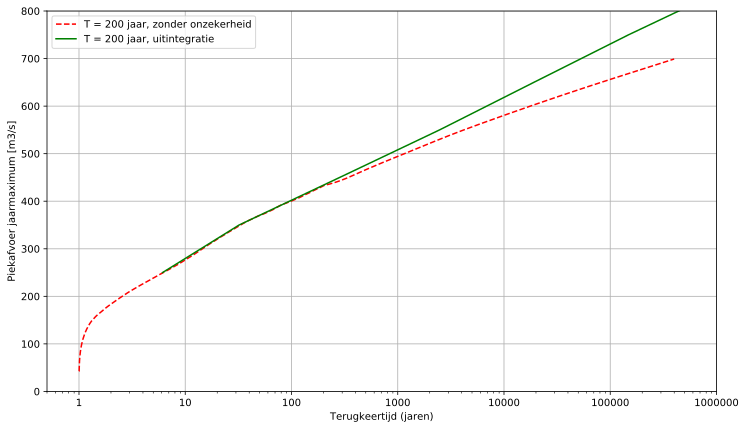

In [113]:
logtscale = True    # Deltares-style log T abcissa
# logtscale = False   # Standard gumbel-axis 
ymax = 800
yrange = 100

from matplotlib.ticker import FormatStrFormatter

ax=plt.gca()
fig=plt.gcf()
def retp(sgv):
    return 1./(1.-np.exp(-np.exp(-sgv)))

abcissa = {}
abcissa_ui = {}
selection = (ymaxset_seas5['sgv']>5)
if logtscale:
    abcissa['seas5'] = retp(ymaxset_seas5['sgv'][selection])
    for thresh in [100,200,500]:                       
        abcissa[thresh] = retp(ymaxset_hvdb[thresh]['sgv'])
        abcissa_ui[thresh] = retp(uitgeintegreerd_all[thresh]['sgv'])
else:
    abcissa['seas5'] = ymaxset_seas5['sgv'][selection]
    for thresh in [100,200,500]:                       
        abcissa[thresh] = ymaxset_hvdb[thresh]['sgv']
        abcissa_ui[thresh] = uitgeintegreerd_all[thresh]['sgv']

ax.plot(abcissa[200],ymaxset_hvdb[200]['Q'],'r--',label='T = 200 jaar, zonder onzekerheid')
ax.plot(abcissa_ui[200][2:] ,uitgeintegreerd_all[200]['levels'][2:],'g-',label="T = 200 jaar, uitintegratie") 
#ax.plot(abcissa['seas5'][selection]),ymaxset_seas5['Q'][selection],'k*', label="SEAS5 maxima")

fig.set_size_inches(12,7)
lgnd = ax.legend(loc="upper left")
ax.set_ylabel('Piekafvoer jaarmaximum [m3/s]')

if logtscale:
    ax.set_xlim([0.5,1E+6])
    ax.set_ylim([0,800])
    ax.set_xscale('log')
    ax.set_xlabel('Terugkeertijd (jaren)')
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
else:
    ax.set_xlim([-1,12])
    gplt.add_gum_axis(Tretlist,ax,ymax,yrange)    
    
ax.grid('y')
# plt.show()
plt.savefig('werklijn200.svg')

thresh = 200

# dump een tabel voor een geselecteerde set van herhalingstijden
print("%8s, %12s, %12s, %12s, %12s, %12s, %12s, %12s, %12s\n"% \
      ('Tr (jr)','sigma_meteo','sigma_hbv','sigma_sbk','sigma_tot', 'Qref [m3/s]', '2.5%', '97.5%', 'Qint [m3/s]'))
for Tr in Tretlist:
    sgv = -np.log(-np.log(1.-1./Tr))
    Qref = interpolate(ymaxset_hvdb[threshold]['sgv'],ymaxset_hvdb[threshold]['Q'],sgv)
    sigma_hbv = interpolate(hbv_uncertainty['tbl_q'], hbv_uncertainty['tbl_sigma'], Qref)
    sigma_sbk = interpolate(sbk_uncertainty['tbl_q'], sbk_uncertainty['tbl_sigma'], Qref)
    sigma_meteo = interpolate(meteo_uncertainty[threshold]['tbl_q'], meteo_uncertainty[threshold]['tbl_sigma'], Qref)
    sigma_tot   = sqrt(sigma_meteo**2. + sigma_hbv**2. + sigma_sbk**2.)
    Qint = interpolate(uitgeintegreerd_all[thresh]['sgv'] ,uitgeintegreerd_all[thresh]['levels'], sgv)
    delta = (sigma_tot - sigma_meteo)/sigma_tot*100.
#   print("%8d, %12.2f, %12.2f, %12.2f, %12.2f, %12.2f, %12.2f"%(Tr,sigma_meteo,sigma_hbv,sigma_sbk,sigma_tot, Qref, Qint))
    print("%8d, %12.2f, %12.2f, %12.2f, %12.2f, %12.2f, %12.2f, %12.2f, %12.2f"% \
                          (Tr,sigma_meteo,sigma_hbv,sigma_sbk,sigma_tot, Qref, Qref-1.96*sigma_tot, Qref+1.96*sigma_tot, Qint))    

In [118]:
def outintegrate_test(parms, levels, distfun):
    # based on a numerical integral over q probabilities
    # this works if we have an ordered set (in terms of reference q) in parms, each with its non-exceedance probability
    # each record in parms consists of a tuple of parameters AND an associated non-exceedance probability
    # has to be ordered on reference Q (that also means ordered by non-exceedance probability) 
    nx = len(parms['F'])
    nl = len(levels)
    cdf = np.array([0.0]*nl)
    H = parms['F']
    wtsum = 0.0
#   for i in range(nx):
    for i in tqdm(list(range(nx))):
        if i==0:
            wt = 0.5*(H[0]+H[1])
        elif i==nx-1:
            wt = 1.-0.5*(H[nx-1]+H[nx-2])
        else:
            wt = 0.5*(H[i+1]-H[i-1])
        wtsum = wtsum + wt
        distribution = all_distributions(distfun, parms['distpar'][i], levels)
        cdf += distribution * wt
    return cdf/wtsum



In [119]:
# uitintegratie stap voor stap voor de onzekerheden afzonderlijk
# * Werklijn + onzekerheid in de meteo invoer (jackknife analyse resampling) -> effectieve werklijn met inbegrip van de onzekerheid
# --> hydrologische variaties op deze uitgeintegreerde werklijn --> werklijn met uitgeitegreerde hydrologische variatie
# --> variaties tgv variaties in de hydraulica --> uitgeintegreerde werklijn met alle onzekerheden
threshold = 200
q_min = 50
q_max = 750

In [120]:
# Stap 1: uitintegratie van de meteorologische onzekerheid uit het jackknife experiment
uitgeintegreerd_meteo = {}
nx_old = len(ymaxset_hvdb[threshold]['sgv'])
parms = {'distpar':[(ymaxset_hvdb[threshold]['Q'][i], ymaxset_hvdb[threshold]['jkstd'][i]) for i in range(nx_old)],
               'F':list(np.exp(-np.exp(-ymaxset_hvdb[threshold]['sgv'])))}
uitgeintegreerd_meteo['levels'] = np.array(list(range(q_min, q_max, 10)))
cdf = outintegrate_test(parms, uitgeintegreerd_meteo['levels'], normal_cdf)
uitgeintegreerd_meteo['sgv'] = -np.log(-np.log(cdf))

C:\Users\leander\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  """


In [121]:
# Stap2: op basis van deze uitgeintegreerde werklijn voor alle levels de standaard deviatie uit het hydrologische experiment
uitgeintegreerd_hbv = {}
nx_old = len(ymaxset_hvdb[threshold]['sgv'])

sigmas = np.array([interpolate(hbv_uncertainty['tbl_q'], hbv_uncertainty['tbl_sigma'], Qref) for Qref in uitgeintegreerd_meteo['levels']])
parms = {'distpar':[t for t in zip(uitgeintegreerd_meteo['levels'], sigmas)],
               'F':list(np.exp(-np.exp(-uitgeintegreerd_meteo['sgv'])))}
uitgeintegreerd_hbv['levels'] = uitgeintegreerd_meteo['levels']
cdf = outintegrate_test(parms, uitgeintegreerd_hbv['levels'], normal_cdf)
uitgeintegreerd_hbv['sgv'] = -np.log(-np.log(cdf))

In [122]:
# Stap3: op basis van deze uitgeintegreerde werklijn voor alle levels de standaard deviatie uit het hydrologische experiment
uitgeintegreerd_sbk = {}
nx_old = len(ymaxset_hvdb[threshold]['sgv'])
sigmas = np.abs(np.array([interpolate(sbk_uncertainty['tbl_q'], sbk_uncertainty['tbl_sigma'], Qref) for Qref in uitgeintegreerd_hbv['levels']]))
sigmas2 = sigmas
parms = {'distpar':[t for t in zip(uitgeintegreerd_hbv['levels'], sigmas*3)],
               'F':list(np.exp(-np.exp(-uitgeintegreerd_hbv['sgv'])))}
uitgeintegreerd_sbk['levels'] = np.arange(100,800,100) # uitgeintegreerd_hbv['levels']
cdf = outintegrate_test(parms, uitgeintegreerd_sbk['levels'], normal_cdf)
uitgeintegreerd_sbk['sgv'] = -np.log(-np.log(cdf))

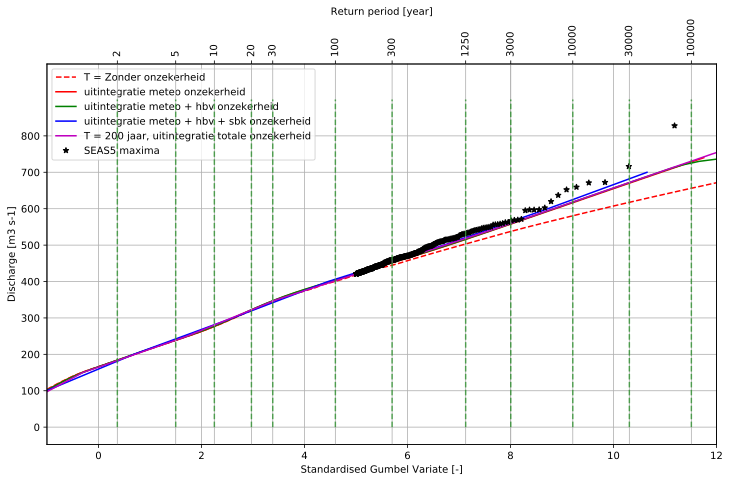

In [123]:
ymax = 900
yrange = 100

ax=plt.gca()
fig=plt.gcf()

ax.plot(ymaxset_hvdb[threshold]['sgv'],ymaxset_hvdb[threshold]['Q'],'r--',label='T = Zonder onzekerheid')
ax.plot(uitgeintegreerd_meteo['sgv'] ,uitgeintegreerd_meteo['levels'],'r-',label="uitintegratie meteo onzekerheid")
ax.plot(uitgeintegreerd_hbv['sgv'] ,uitgeintegreerd_hbv['levels'],'g-',label="uitintegratie meteo + hbv onzekerheid")
ax.plot(uitgeintegreerd_sbk['sgv'] ,uitgeintegreerd_sbk['levels'],'b-',label="uitintegratie meteo + hbv + sbk onzekerheid")
ax.plot(uitgeintegreerd_all[threshold]['sgv'] ,uitgeintegreerd_all[threshold]['levels'],'m-',label='T = %d jaar, uitintegratie totale onzekerheid'%threshold)

#ax.plot(ymaxset_seas5['sgv'],ymaxset_seas5['Q'],'k*', label="SEAS5 maxima")
selection = (ymaxset_seas5['sgv']>5)
ax.plot(ymaxset_seas5['sgv'][selection],ymaxset_seas5['Q'][selection],'k*', label="SEAS5 maxima")
fig.set_size_inches(12,7)
lgnd = ax.legend(loc="upper left")
ax.set_xlim([-1,12])
gplt.add_gum_axis(Tretlist,ax,ymax,yrange)    
plt.show()

In [138]:
Tr = 30000.
sgv = -np.log(-np.log(1.-1./Tr))
Q1 = interpolate(uitgeintegreerd_sbk['sgv'] ,uitgeintegreerd_sbk['levels'],sgv)
Q0 = interpolate(uitgeintegreerd_all[threshold]['sgv'] ,uitgeintegreerd_all[threshold]['levels'],sgv)
print ("Bij een herhalingstijd van %d jaar (sgv = %f)"%(Tr,sgv))
print("Successievelijke uitintegratie           : %f m3/s"%Q1)
print("Uitintegratie van de totale onzekerheid  : %f m3/s"%Q0)
print("Absolute fout                            : %f m3/s"%(Q1-Q0))
print("Relatieve fout                           : %f %%"%((Q1-Q0)*100./Q0))

Bij een herhalingstijd van 30000 jaar (sgv = 10.308936)
Successievelijke uitintegratie           : 682.202802 m3/s
Uitintegratie van de totale onzekerheid  : 672.001803 m3/s
Absolute fout                            : 10.200999 m3/s
Relatieve fout                           : 1.518002 %


Text(10, 10, '3')

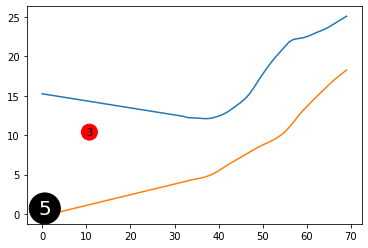

In [316]:
def setnr(ax,x,y,nodenr,color):
    plt.text(0.6, 0.7, "%d"%nodenr, size=20,
         ha="center", va="center", color=tuple(1.-col for col in color),
         bbox=dict(boxstyle="circle",
                   ec=color, fc=color,
                   )
         )


plt.plot(sigmas1)
plt.plot(sigmas2)
setnr(plt.gca(),10,20,5,(0,0,0))
plt.text(10,10,"%d"%3,bbox={"boxstyle" : "circle", "color":'r'})

In [305]:
def setnr(ax,x,y,nodenr,color):
    plt.text(0.6, 0.7, "%d"%nodenr, size=20,
         ha="center", va="center", color=(1.,1.,1.),
         bbox=dict(boxstyle="circle",
                   ec=(1., 0.5, 0.5),
                   fc=(1., 0.2, 0.2),
                   )
         )

